In [1]:
# Utils
import os, sys, re, time, gc, types, string, unicodedata, unidecode, string, warnings, inspect

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
import pickle

from sklearn.metrics import accuracy_score
from IPython.display import display, Markdown, Latex

import shutil

from tensorflow.contrib.learn import DNNClassifier
import scikitplot as skplt

import scipy
#plt.style.use('fivethirtyeight')

/root/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Parameters

In [2]:
root_path = "../"
path_model = root_path + 'models/testV2'
#features_path = root_path + 'data/features/data_tfid_hash28_n1000_SVD2.p'
#features_path = root_path + 'data/features/data_tfid_hash28_n10000_bigram_svd1000.p'
#features_path = root_path + 'data/features/data_tfid_hash28_n1000.p'

features_path = root_path + 'data/features/dataV2_tfid_hash28_n10000_svd1000_sin_stemmig.p'
#features_path = root_path + 'data/features/dataV2_tfid_hash28_n10000_svd1000_bigram_sin_stemmig.p'
#features_path = root_path + 'data/features/dataV2_tfid_hash28_n10000_svd1000_bigram_con_stemmig.p'





# Load Data

### Output

In [3]:
X ,y1 ,y2 , y3 = pickle.load( open( features_path, "rb" ) )


In [4]:

fraction = 0.1
np.random.seed(42)
indices = np.random.choice(X.shape[0], round(fraction*X.shape[0]), replace=False)

X = X[indices]
y1 = y1[indices]

X.shape[0]

35155

In [5]:
train_fraction = 0.70

y1 = y1.values    

np.random.seed(42)
train_indices = np.random.choice(X.shape[0], round(train_fraction*X.shape[0]), replace=False)
test_indices = np.array(list(set(range(X.shape[0])) - set(train_indices)))

X_train = X[train_indices]
y_train = y1[train_indices]
X_test = X[test_indices]
y_test = y1[test_indices]


In [6]:
labels = list(set(y_train))
labels.sort()
nClasses = len(labels)

def calcWeights(y):
    sizes = {label: y_train[y_train == label].shape[0] for label in labels}
    weights = np.asarray([float(len(y_train))/(sizes[label]*nClasses) for label in y]) #n_samples / (n_classes * np.bincount(y))
    weights = np.power(weights,1) # 1.4
    return weights 

def calcWeightsL(y):
    #lerko
    scale_factor = 10e3
    sizes = {label: y_train[y_train == label].shape[0] for label in labels}
    weights = np.asarray([scale_factor/sizes[label] for label in y])
    return weights 

weights_train = calcWeights(y_train)
weights_test = calcWeights(y_test)

# Model

### DNN graph generation

In [7]:
epochs = 20000

if isinstance(X_train, scipy.sparse.csr.csr_matrix):
    X_train = X_train.todense()
    X_test = X_test.todense()

# Define the test inputs
def get_train_inputs():    
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_train,'class_weights': weights_train},
                                                  y_train[:,np.newaxis],
                                                  shuffle=True,
                                                  batch_size=64, #min 64 , best at 1024
                                                  num_epochs=epochs)
    return dataset

def get_test_inputs():
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_test,'class_weights': weights_test},
                                                  y_test[:,np.newaxis],
                                                  shuffle=False)
    return dataset

### functions graph tensorflow

In [8]:



feature_columns = [tf.contrib.layers.real_valued_column('x', dimension=X_train.shape[1])]

optimizer = tf.train.ProximalAdagradOptimizer(
                              learning_rate=10.0,
                              l1_regularization_strength= 0.0#0.0001
                              )

classifier = DNNClassifier(                                
                           n_classes=len(labels), label_keys=labels, feature_columns=feature_columns,
                           hidden_units=[3000,2000], #2000, 1000, 100
                           dropout=0.5,
                           #optimizer = optimizer,
                           weight_column_name='class_weights',
                           model_dir = path_model,
                           config = tf.contrib.learn.RunConfig(save_checkpoints_steps = 4096,
                           save_checkpoints_secs = None)                           
                          )

Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
INFO:tensorflow:Using config: {'_evaluation_master': '', '_tf_random_seed': None, '_log_step_count_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_session_config': None, '_task_type': None, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_train_distribute': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f385c9e8b70>, '_save_checkpoints_secs': None, '_model_dir': '../models/testV2', '_task_id': 0, '_keep_checkpoint_max': 5, '_device_fn': None, '_save_summary_steps': 100, '_environment': 'local', '_num_worker_replicas': 0, '_is_chief': True, '_master': '', '_save_checkpoints_steps': 4096}


# Training



In [9]:
tf.set_random_seed(42)

delete_old_model = True
if delete_old_model:
    try:
        os.system("rm -rf "+path_model)
        os.system("mkdir "+path_model)
    except:
        print("error")
    
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    #input_fn= get_train_inputs(),
    input_fn= get_test_inputs(),
    
    every_n_steps=500,
    #early_stopping_metric="accuracy",   #accurray mucho mas rapido,7s vs 40s, pero 2% peor
    early_stopping_metric="loss",   
    early_stopping_metric_minimize=True,
    early_stopping_rounds=2500)

start = time.time()
print("start")

#classifier.fit(input_fn=get_train_inputs(), monitors=[validation_monitor], steps=epochs, max_steps=None)
classifier.fit(input_fn=get_train_inputs(), monitors=[validation_monitor], steps=epochs, max_steps=None)

end = time.time()
print("Training time :" + str(end - start) )


Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
start
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ../models/testV2/model.ckpt.
INFO:tensorflow:loss = 1.940064, step = 0
INFO:tensorflow:global_step/sec: 224.855
INFO:tensorflow:loss = 1.9568409, step = 100 (0.445 sec)
INFO:tensorflow:global_step/sec: 291.283
INFO:tensorflow:loss = 1.9480684, step = 200 (0.343 sec)
INFO:tensorflow:global_step/sec: 289.793
INFO:tensorflow:loss = 2.195644, step = 300 (0.345 sec)
INFO:tensorflow:global_step/sec: 290.462
INFO:tensorflow:loss = 0.97744954, step = 400 (0.345 sec)
INFO:tensorflow:global_step/sec: 288.8
INFO:tensorflow:Starting

INFO:tensorflow:global_step/sec: 284.82
INFO:tensorflow:loss = 0.10067557, step = 5900 (0.351 sec)
INFO:tensorflow:global_step/sec: 286.76
INFO:tensorflow:loss = 0.1518439, step = 6000 (0.348 sec)
INFO:tensorflow:global_step/sec: 293.169
INFO:tensorflow:loss = 0.028291574, step = 6100 (0.341 sec)
INFO:tensorflow:global_step/sec: 286.702
INFO:tensorflow:loss = 0.042095445, step = 6200 (0.349 sec)
INFO:tensorflow:global_step/sec: 287.957
INFO:tensorflow:loss = 0.11753271, step = 6300 (0.347 sec)
INFO:tensorflow:global_step/sec: 290.66
INFO:tensorflow:loss = 0.15172522, step = 6400 (0.344 sec)
INFO:tensorflow:global_step/sec: 287.311
INFO:tensorflow:loss = 0.2936502, step = 6500 (0.350 sec)
INFO:tensorflow:global_step/sec: 290.202
INFO:tensorflow:loss = 0.16365235, step = 6600 (0.343 sec)
INFO:tensorflow:global_step/sec: 291.753
INFO:tensorflow:loss = 0.10400267, step = 6700 (0.342 sec)
INFO:tensorflow:global_step/sec: 288.761
INFO:tensorflow:loss = 0.09064878, step = 6800 (0.346 sec)
INF

# Evaluation performance


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/testV2/model.ckpt-9501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


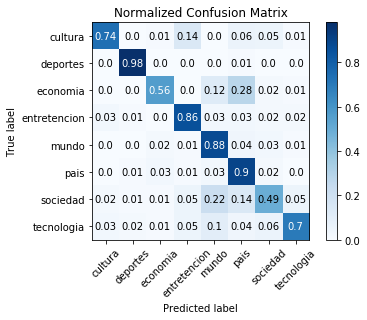

## Accuracy in test: 89.35242248980752 

In [10]:
#X_test = X_test.todense().p'

def input_fn_evaluate():
    dataset = {'x': tf.constant(X_test )}    
    return dataset

pred_test = classifier.predict_classes(input_fn=input_fn_evaluate)
y_test_hat = np.asarray([x.decode('UTF-8') for x in list(pred_test)])
y_test_hat = y_test_hat.astype(str)


acc = accuracy_score(y_true=y_test, y_pred=y_test_hat)

skplt.metrics.plot_confusion_matrix(y_test, y_test_hat,normalize='True')
plt.xticks(rotation=45)
plt.show()

#print('Accuracy in test: {}'.format(acc))
display(Markdown('## Accuracy in test: {} '.format(acc*100)))

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/testV2/model.ckpt-9501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


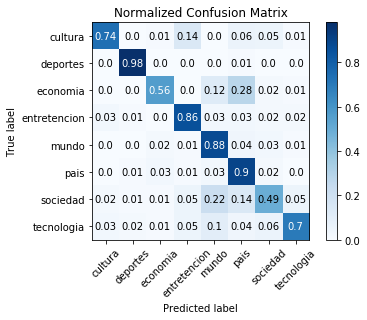

## Mean diag. principal confusion Matrix : 76.28121144607715 

## Accuracy in test: 89.35242248980752 

In [11]:
#X_test = X_test.todense()

def input_fn_evaluate():
    dataset = {'x': tf.constant(X_test )}    
    return dataset

pred_test = classifier.predict_classes(input_fn=input_fn_evaluate)
y_test_hat = np.asarray([x.decode('UTF-8') for x in list(pred_test)])
y_test_hat = y_test_hat.astype(str)


acc = accuracy_score(y_true=y_test, y_pred=y_test_hat)
cfm = skplt.metrics.confusion_matrix(y_test, y_test_hat)
cfm = cfm/cfm.astype(np.float).sum(axis=1)
mdp = np.mean(cfm.diagonal())

skplt.metrics.plot_confusion_matrix(y_test, y_test_hat,normalize='True')
plt.xticks(rotation=45)
plt.show()

#print('Accuracy in test: {}'.format(acc))
display(Markdown('## Mean diag. principal confusion Matrix : {} '.format(mdp*100)))

display(Markdown('## Accuracy in test: {} '.format(acc*100)))


### save models

In [12]:

pickle.dump( (path_model,labels), open( path_model + "/info_model.p", "wb" ) )

In [13]:
# def input_fn_evaluate1():
#     dataset = {'x': tf.constant(X_test[0:25000,:].todense() )}    
#     return dataset

# pred_test1 = classifier.predict_classes(input_fn=input_fn_evaluate1)

# def input_fn_evaluate2():
#     dataset = {'x': tf.constant(X_test[25000:,:].todense() )}    
#     return dataset
# pred_test2 = classifier.predict_classes(input_fn=input_fn_evaluate2)50


In [14]:
# y_test_hat1 = np.asarray([x.decode('UTF-8') for x in list(pred_test1)])
# y_test_hat2 = np.asarray([x.decode('UTF-8') for x in list(pred_test2)])
# y_test_hat = np.concatenate((y_test_hat1, y_test_hat2), axis=0)

In [15]:

# y_test_hat = y_test_hat.astype(str)


# acc = accuracy_score(y_true=y_test, y_pred=y_test_hat)

# skplt.metrics.plot_confusion_matrix(y_test, y_test_hat,normalize='True')
# plt.xticks(rotation=45)
# plt.show()

# #print('Accuracy in test: {}'.format(acc))
# display(Markdown('## Accuracy in test: {} '.format(acc*100)))